# Aula 06 - Feature Selection e CV

A aula de hoje abordará 3 tópicos diferentes: feature selection, cross validation e, como extra, o algoritmo Naive Bayes:

### - Primeira parte

- Cross Validation
- Feature Selection
- Boruta

### - Segunda parte

- EXTRA: Naive Bayes

### - Terceira parte

- Finalização dos exercícios

# Motivação

## Validação de modelos

Sempre que estamos desenvolvendo um novo modelo, precisamos medir a sua performance. É isso que nos guiará nos processos de tomada de decisão sobre o algoritmo a ser utilizado, a escolha dos hiperparâmetros, etc. Existem diversas formas de se avaliar um modelo, porém todas seguem um mesmo princípio: precisamos analisar as predições em dados nunca vistos no treinamento.   

### Hold-out

(__out of time__ em séries temporais)

Essa é a técnica que mais utilizados até aqui: deixamos um pedaço do dataset fora do treino. Utilizamos o *train_test_split* do sklearn na implementação.  

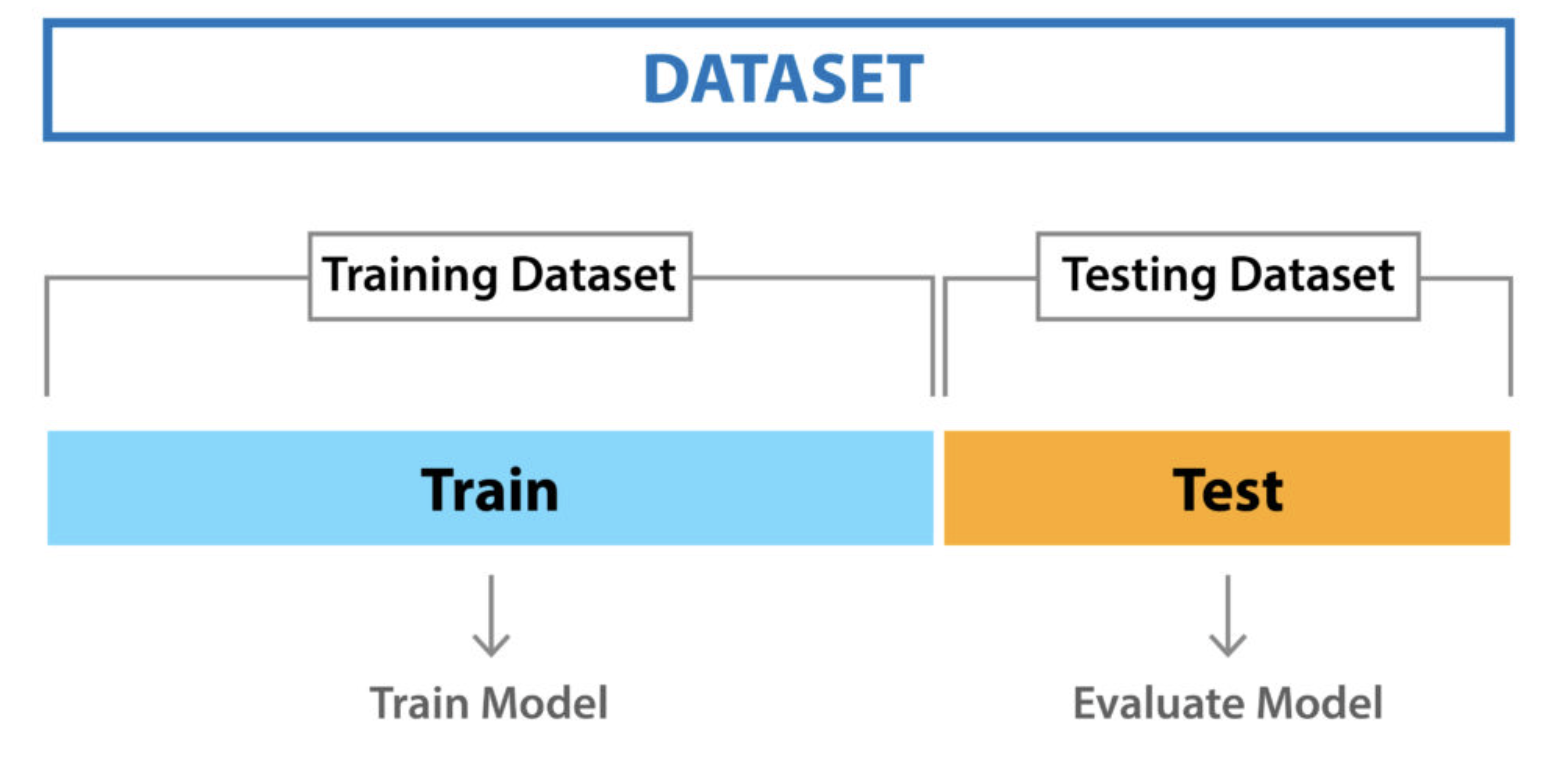


### Cross Validation (validação cruzada)

Vimos o Cross Validation em funcionamento quando utilizados o *GridSearch*. Essa técnica é a mais robusta para fazer a seleção de hiperparâmetros, pois evitamos eventuais viéses na separação da base de treino.

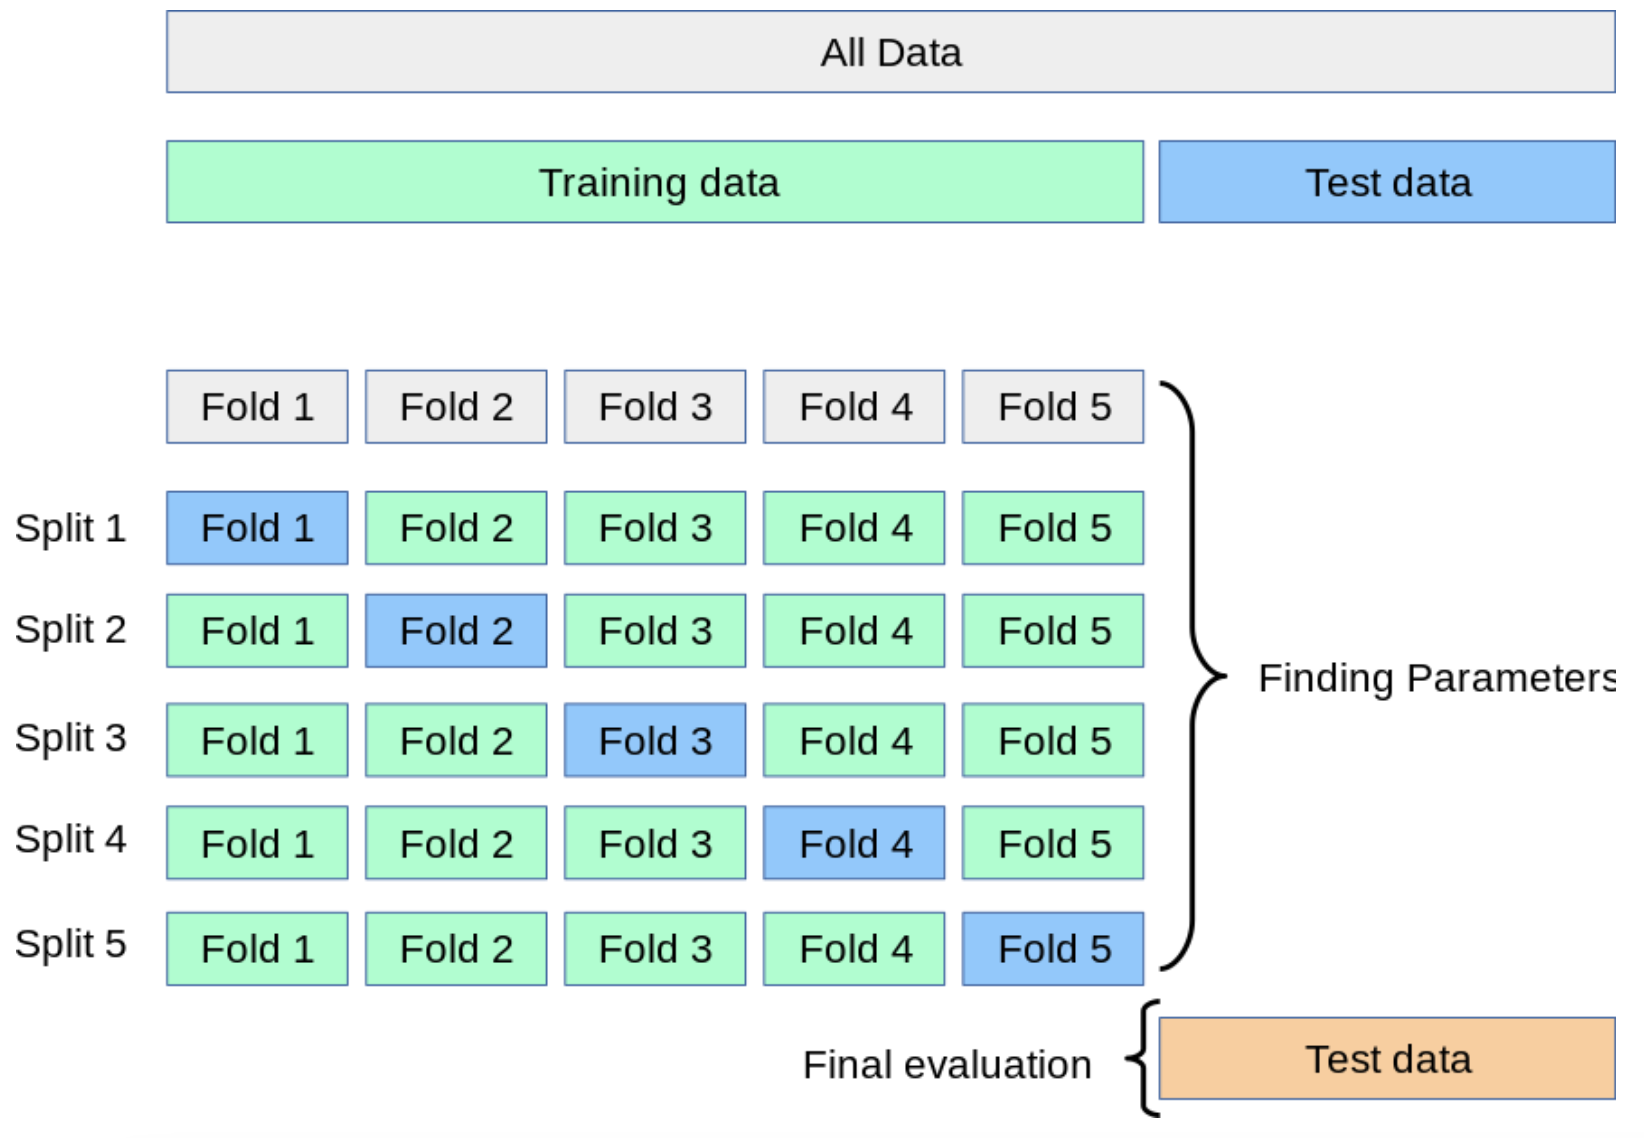

Para cada etapa de treino e validação, calculamos a métrica do modelo. É comum avaliarmos dois tipos de propriedades: a média e o desvio padrão das validações.  

Há pelo menos duas maneiras de se implementar o Cross Validation com as ferramentas do sklearn: [cross_validate](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) ou [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html?highlight=stratifiedkfold#sklearn.model_selection.StratifiedKFold).  



# Exemplos

In [1]:
import pandas as pd
import numpy as np

In [2]:
base_treino = pd.read_csv('adult_train.csv')

base_treino.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,17,Private,144752,10th,6,Never-married,Handlers-cleaners,Own-child,Amer-Indian-Eskimo,Male,0,0,20,United-States,<=50K
1,21,Local-gov,402230,Some-college,10,Never-married,Adm-clerical,Unmarried,White,Male,0,0,36,United-States,<=50K
2,41,Private,149576,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,>50K
3,29,Private,535978,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,45,United-States,<=50K
4,54,Private,111469,Some-college,10,Divorced,Exec-managerial,Not-in-family,White,Female,0,0,40,United-States,<=50K


In [3]:
base_treino.nunique()

age                   74
workclass              9
fnlwgt             24668
education             16
educational-num       16
marital-status         7
occupation            15
relationship           6
race                   5
gender                 2
capital-gain         119
capital-loss          97
hours-per-week        95
native-country        42
income                 2
dtype: int64

In [4]:
base_treino['income'] = base_treino['income'].map({'<=50K': 0, '>50K': 1})

In [5]:
categ_features = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']
num_features = ['age', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']

In [6]:
X = base_treino[categ_features + num_features]
y = base_treino['income']

print(X.shape, y.shape)

(39074, 12) (39074,)


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, 
                                                    y, 
                                                    test_size=0.1, 
                                                    random_state=12)

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(35166, 12) (35166,)
(3908, 12) (3908,)


In [8]:
from sklearn.preprocessing import OrdinalEncoder
pd.options.mode.chained_assignment = None

oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

oe.fit(X_train[categ_features])

X_train[categ_features] = oe.transform(X_train[categ_features])

X_valid[categ_features] = oe.transform(X_valid[categ_features])

X_train.head()

,workclass,marital-status,occupation,relationship,race,gender,native-country,age,educational-num,capital-gain,capital-loss,hours-per-week
8220,6.0,2.0,3.0,0.0,4.0,1.0,39.0,43,9,0,0,60
10078,2.0,2.0,10.0,0.0,4.0,1.0,39.0,34,14,0,0,41
25853,4.0,2.0,4.0,0.0,4.0,1.0,39.0,50,13,0,1902,40
20939,4.0,2.0,7.0,0.0,1.0,1.0,35.0,33,9,0,0,40
5460,1.0,0.0,6.0,4.0,2.0,1.0,39.0,43,11,0,1726,40


#### cross_validate

In [16]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(max_depth=5, random_state=12)

In [32]:
from sklearn.model_selection import cross_validate

cv = cross_validate(model, X_train, y_train, scoring=['recall', 'f1'], return_train_score=True, cv=2)

print(cv)

{'fit_time': array([0.48013186, 0.45186996]), 'score_time': array([0.09113216, 0.10398412]), 'test_recall': array([0.490233  , 0.48917647]), 'train_recall': array([0.50541176, 0.48505531]), 'test_f1': array([0.6089753 , 0.61246133]), 'train_f1': array([0.62233811, 0.60949283])}


In [22]:
media_score_treino = cv['train_score'].mean()
media_score_valid = cv['test_score'].mean()

desvio_score_treino = cv['train_score'].std()
desvio_score_valid = cv['test_score'].std()

print(f'Score de treino: {media_score_treino:.2f} {desvio_score_treino:.4f}')
print(f'Score de valid: {media_score_valid:.2f} {desvio_score_valid:.4f}')

Score de treino: 0.62 0.0064
Score de valid: 0.61 0.0017


In [23]:
cv

{'fit_time': array([0.48338604, 0.43896294]),
 'score_time': array([0.09214187, 0.08497   ]),
 'test_score': array([0.6089753 , 0.61246133]),
 'train_score': array([0.62233811, 0.60949283])}

#### StratifiedKFold

In [24]:
# Utilizando o StratifiedKFold

from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5)
kf.get_n_splits(X_train)

5

In [26]:
next(kf.split(X_train, y_train))

(array([ 7002,  7003,  7005, ..., 35163, 35164, 35165]),
 array([   0,    1,    2, ..., 7045, 7046, 7047]))

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

list_accuracy = []
list_precision = []
list_recall = []
list_f1_score = []

i = 1
for train_index, val_index in kf.split(X_train, y_train):
    print("============================================================================================")
    print("Fold ", i)
    print("TRAIN:", train_index, "VALIDATION:", val_index)
    KFold_X_train, KFold_X_val = X_train.iloc[train_index], X_train.iloc[val_index]
    KFold_y_train, KFold_y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    model.fit(KFold_X_train, KFold_y_train)
    y_pred = model.predict(KFold_X_val)
    #Calcula as métricas
    acc = accuracy_score(KFold_y_val, y_pred)
    prec = precision_score(KFold_y_val, y_pred)
    recall = recall_score(KFold_y_val, y_pred)
    f1 = f1_score(KFold_y_val, y_pred)
    print("Accuracy: ", acc)
    print("Precison: ", prec)
    print("Recall:    ", recall)
    print("F1-Score: ", f1)
    
    if recall < 0.48:
        KFold_X_train['target'] = KFold_y_train
        KFold_X_train.to_csv(f'fold_{i}_problema.csv')
        
    # salva na lista
    list_accuracy.append(acc)
    list_precision.append(prec)
    list_recall.append(recall)
    list_f1_score.append(f1)
    i += 1
print("============================================================================================")

Fold  1
TRAIN: [ 7002  7003  7005 ... 35163 35164 35165] VALIDATION: [   0    1    2 ... 7045 7046 7047]
Accuracy:  0.8473130508956497
Precison:  0.8148893360160966
Recall:     0.4764705882352941
F1-Score:  0.6013363028953229
Fold  2
TRAIN: [    0     1     2 ... 35163 35164 35165] VALIDATION: [ 7002  7003  7005 ... 14071 14072 14073]
Accuracy:  0.8488553959903313
Precison:  0.818
Recall:     0.48145968216598
F1-Score:  0.6061504260837348
Fold  3
TRAIN: [    0     1     2 ... 35163 35164 35165] VALIDATION: [14038 14042 14053 ... 21158 21159 21160]
Accuracy:  0.8536897483293047
Precison:  0.8198284080076264
Recall:     0.5058823529411764
F1-Score:  0.6256820662058931
Fold  4
TRAIN: [    0     1     2 ... 35163 35164 35165] VALIDATION: [21072 21073 21075 ... 28263 28265 28267]
Accuracy:  0.8516991326603156
Precison:  0.8186226964112512
Recall:     0.4964705882352941
F1-Score:  0.6180886122299524
Fold  5
TRAIN: [    0     1     2 ... 28263 28265 28267] VALIDATION: [28080 28081 28082 ... 3

## Feature Selection

### Baseado em modelo

In [56]:
model = RandomForestClassifier(max_depth=4, n_estimators=30, criterion='entropy', bootstrap=False, max_features=1)

model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=4,
                       max_features=1, n_estimators=30)

In [57]:
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
std

array([0.01798322, 0.27025983, 0.04788945, 0.18751944, 0.01258759,
       0.08119029, 0.00448886, 0.20396825, 0.18281564, 0.22663902,
       0.06620293, 0.1035732 ])

In [59]:
importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_,
    'std': std}).sort_values('importance', ascending=False)

importances

,feature,importance,std
1,marital-status,0.241944,0.270260
9,capital-gain,0.153527,0.226639
8,educational-num,0.141830,0.182816
7,age,0.125489,0.203968
3,relationship,0.097838,0.187519
11,hours-per-week,0.077105,0.103573
10,capital-loss,0.057599,0.066203
5,gender,0.048422,0.081190
2,occupation,0.034889,0.047889
0,workclass,0.011745,0.017983


### Forward/Backward selection

Adiciona ou remove as features de maneira sequencial. A variação na métrica de avaliação é o que trará a importância da feature.

In [65]:
from sklearn.feature_selection import SequentialFeatureSelector

model = RandomForestClassifier(max_depth=4, n_estimators=30)

feature_selection = SequentialFeatureSelector(model, n_features_to_select=2, cv=2, scoring='recall')

In [66]:
feature_selection.fit(X_train, y_train)

SequentialFeatureSelector(cv=2,
                          estimator=RandomForestClassifier(max_depth=4,
                                                           n_estimators=30),
                          n_features_to_select=0.5, scoring='recall')

In [67]:
selected_features = feature_selection.get_support()

In [68]:
selected_features

array([False,  True, False,  True, False, False,  True, False,  True,
        True,  True, False])

In [69]:
list_features = X_train.columns[selected_features]

Index(['marital-status', 'relationship', 'native-country', 'educational-num',
       'capital-gain', 'capital-loss'],
      dtype='object')

### Boruta

[Docs](https://github.com/scikit-learn-contrib/boruta_py)

In [71]:
from boruta import BorutaPy

In [75]:
X_train['workclass'] = X_train['workclass'].sample(frac=1.).values

In [76]:
X_train

,workclass,marital-status,occupation,relationship,race,gender,native-country,age,educational-num,capital-gain,capital-loss,hours-per-week
8220,1.0,2.0,3.0,0.0,4.0,1.0,39.0,43,9,0,0,60
10078,4.0,2.0,10.0,0.0,4.0,1.0,39.0,34,14,0,0,41
25853,4.0,2.0,4.0,0.0,4.0,1.0,39.0,50,13,0,1902,40
20939,6.0,2.0,7.0,0.0,1.0,1.0,35.0,33,9,0,0,40
5460,4.0,0.0,6.0,4.0,2.0,1.0,39.0,43,11,0,1726,40
...,...,...,...,...,...,...,...,...,...,...,...,...
9475,4.0,2.0,7.0,0.0,4.0,1.0,39.0,27,12,0,0,40
36482,4.0,4.0,10.0,1.0,4.0,1.0,39.0,44,14,8614,0,33
19709,4.0,2.0,10.0,0.0,4.0,1.0,39.0,46,15,15024,0,40
38555,4.0,2.0,12.0,5.0,4.0,0.0,39.0,23,10,0,0,35


In [77]:
feat_selector = BorutaPy(model, n_estimators='auto', verbose=2, random_state=1)

feat_selector.fit(X_train.values, y_train.values)

feat_selector.support_

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	11
Tentative: 	0
Rejected: 	1


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	11
Tentative: 	0
Rejected: 	1


array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [79]:
feat_selector.ranking_

array([2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

# EXTRA: Naive Bayes

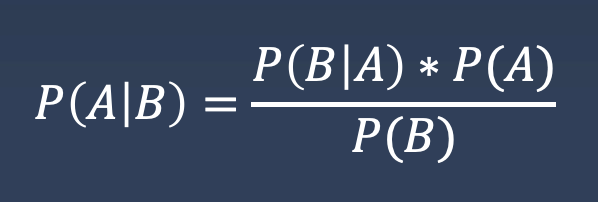

| x1 | x2 | y |
| --- | --- | --- |
| H | C | 1 |
| H | D | 1 |
| L | C | 0 |
| L | D | 1 |
| H | C | 0 |
| H | D | 0 |

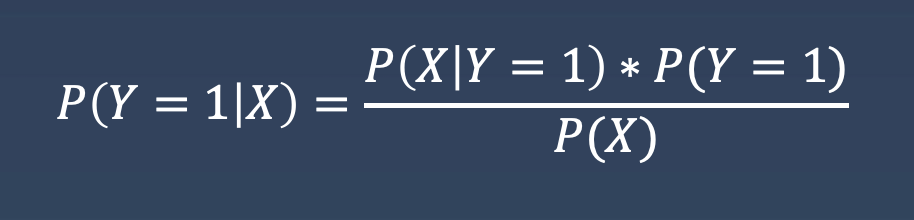

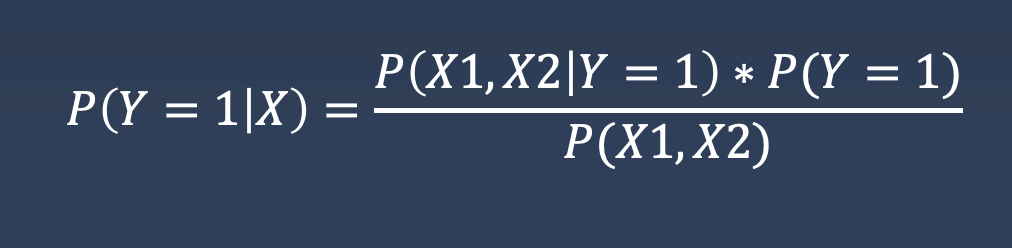

Assumindo a independência das variáveis de entrada

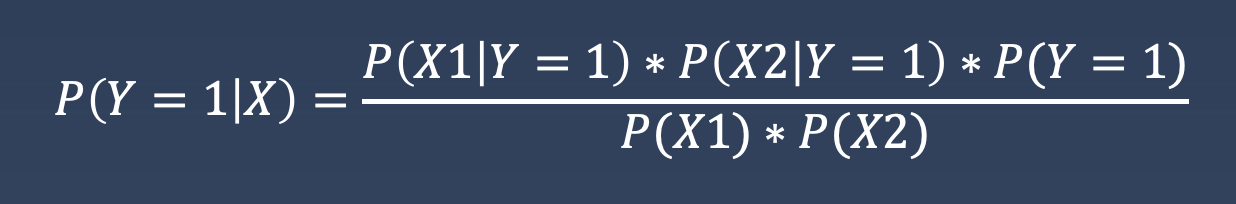

### Implementando

In [82]:
nb_train = X_train[['marital-status', 'gender']]
nb_train['y'] = y_train

nb_train.head()

,marital-status,gender,y
8220,2.0,1.0,0
10078,2.0,1.0,1
25853,2.0,1.0,1
20939,2.0,1.0,0
5460,0.0,1.0,0


In [117]:
marital_status = 1
gender = 1

In [118]:
p_y_igual_1 = nb_train['y'].value_counts(normalize=True)[1]
p_y_igual_1

0.24168230677358812

In [119]:
p_x2_y_igual_1 = nb_train.loc[nb_train['y'] == 1, 'gender'].value_counts(normalize=True)[gender]
p_x2_y_igual_1

0.84633486292505

In [120]:
p_x1_y_igual_1 = nb_train.loc[nb_train['y'] == 1, 'marital-status'].value_counts(normalize=True)[marital_status]
p_x1_y_igual_1

0.0015295917166725497

In [121]:
p_x2 = nb_train['gender'].value_counts(normalize=True)[gender]
p_x2

0.6667519763407838

In [122]:
p_x1 = nb_train['marital-status'].value_counts(normalize=True)[marital_status]
p_x1

0.0007677870670534039

In [123]:
probabilidade_y_igual_1 = (p_x1_y_igual_1 * p_x2_y_igual_1 * p_y_igual_1) / (p_x1 * p_x2)

probabilidade_y_igual_1

0.6111636381896602

-------

### sklearn

In [127]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB

In [130]:
modelo = MultinomialNB()

modelo.fit(X_train, y_train)

MultinomialNB()

In [131]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

y_train_pred = modelo.predict(X_train)

y_valid_pred = modelo.predict(X_valid)

print(y_train_pred.shape, y_valid_pred.shape)

acc_train = accuracy_score(y_train, y_train_pred)
prec_train = precision_score(y_train, y_train_pred)
rec_train = recall_score(y_train, y_train_pred)

acc_valid = accuracy_score(y_valid, y_valid_pred)
prec_valid = precision_score(y_valid, y_valid_pred)
rec_valid = recall_score(y_valid, y_valid_pred)

print(f'Treino:\nAcc: {acc_train:.2f}, Precision: {prec_train:.2f}, Recall: {rec_train:.2f}')
print(f'Validação:\nAcc: {acc_valid:.2f}, Precision: {prec_valid:.2f}, Recall: {rec_valid:.2f}')

(35166,) (3908,)
Treino:
Acc: 0.78, Precision: 0.62, Recall: 0.21
Validação:
Acc: 0.78, Precision: 0.58, Recall: 0.19


# Pra anotar

- CrossValidation é **necessário** durante o desenvolvimento do seu modelo. É uma técnica que evita conclusões equivocadas e permite uma melhor escolha dos hiperparâmetros;
- Feature Selection é uma técnica que pode reduzir custos e gerar resultados intermediários excelentes. Sempre reflita sobre os resultados que obtiver;
- NaiveBayes é um algoritmo limitado, mas tem desempenho satisfatório quando as features são contagens.

-------